#**A PROBABILISTIC GRAPHICAL MODEL APPROACH TO HEART DISEASE PREDICTION USING UCI CLEVELAND DATASET**


#***Abstract***


Heart disease is one of the leading causes of mortality worldwide. Early prediction of heart disease risk can significantly improve patient outcomes by enabling timely intervention. This study investigates the application of probabilistic graphical models (PGMs), specifically Bayesian Networks, to predict the likelihood of heart disease using the UCI Cleveland Heart Disease dataset. We employed two popular PGM libraries, pgmpy and pomegranate, to construct, learn, and infer Bayesian models. Structure learning was performed via Hill-Climb Search in pgmpy, while pomegranate was applied with both predefined and learned structures. Experiments compared model accuracy, inference speed, and interpretability.

## ***I. Intoduction***

Cardiovascular diseases (CVDs) represent a major health burden globally, responsible for over 17 million deaths annually. Predicting the probability of heart disease is essential for preventive healthcare and clinical decision-making. Traditional machine learning approaches such as logistic regression, support vector machines, or neural networks achieve high predictive accuracy but often lack interpretability.

Probabilistic Graphical Models (PGMs), particularly Bayesian Networks (BNs), provide a principled framework for modeling conditional dependencies among variables. Unlike black-box classifiers, BNs yield interpretable probabilistic relationships, allowing clinicians to understand how risk factors such as age, cholesterol level, or chest pain influence heart disease outcomes.

This report explores the application of Bayesian Networks to heart disease prediction, focusing on two state-of-the-art open-source libraries: pgmpy and pomegranate.

## ***II. Related works***

Bayesian networks have been applied to medical diagnosis tasks for decades. Early works demonstrated their utility in modeling causal relationships in disease progression. For heart disease, several studies have benchmarked BNs on the UCI Cleveland dataset, reporting competitive performance compared to logistic regression and decision trees.

Recent frameworks such as pgmpy (Python) provide comprehensive support for Bayesian Network learning and inference . Meanwhile, pomegranate offers high-performance implementations of probabilistic models, including Bayesian Networks and Hidden Markov Models . Comparative studies show that pgmpy is often favored for exact inference, while pomegranate provides speed and flexibility with approximate inference .

## ***III. Problem Statements and Related Definitions***

### ***3.1 Problem Statement***

Given a dataset of patient attributes $ X = \{x_1, x_2, \ldots, x_n\} $, including demographic and clinical risk factors, the goal is to predict the target variable $ Y $ representing the presence of heart disease.

Formally:

- **Learning phase**: Given training data $ (X, Y) $, learn the Bayesian Network structure $ G $ and conditional probability tables (CPTs) $ \theta $.

- **Inference phase**: For a new patient with partial evidence $ X_e \subseteq X $, compute the posterior distribution:

$$
P(Y \mid X_e, G, \theta)
$$

### ***3.2 Related Definitions***

**Probabilistic Graphical Model (PGM):**  
A statistical model that represents the joint probability distribution of a set of random variables using a graph, where nodes correspond to variables and edges encode conditional dependencies.  

**Bayesian Network (BN):**  
A directed acyclic graph (DAG) representing variables and their conditional dependencies. The joint distribution factorizes as:  

$$
P(X_1, X_2, \ldots, X_n) = \prod_{i=1}^n P(X_i \mid Pa(X_i))
$$  

where $Pa(X_i)$ denotes the parent set of $X_i$.  

**Structure Learning:**  
The process of determining the network structure $G$ from data, typically using scoring functions (e.g., BIC, K2) combined with search strategies (e.g., Hill-Climb Search).  

**Parameter Learning:**  
The estimation of CPTs $\theta$, usually performed via Maximum Likelihood Estimation (MLE) or Bayesian Estimation, based on the given network structure.  

**Inference:**  
The computation of posterior probabilities of unobserved variables given observed evidence.  
For example, estimating:  

$$
P(Y=1 \mid X_e)
$$  

allows us to infer the likelihood of heart disease for a new patient based on available risk factors.  


In [1]:
# =======================================================
# 1. Setup & Imports
# =======================================================
!pip install --quiet pgmpy pomegranate matplotlib networkx seaborn scikit-learn pandas

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, brier_score_loss, roc_curve, auc

# pgmpy
from pgmpy.estimators import HillClimbSearch
from pgmpy.models import DiscreteBayesianNetwork as PgmpyBN
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# pomegranate
from pomegranate.bayesian_network import BayesianNetwork as PomBN
from sklearn.impute import SimpleImputer

sns.set(style="whitegrid")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 11.8 MB/s eta 0:00:00


In [2]:
# =======================================================
# 2. Load Dataset (Heart Disease UCI)
# =======================================================
df = pd.read_csv("heart_disease_uci.csv")

target_col = "num"
df[target_col] = df[target_col].apply(lambda x: 1 if x > 0 else 0)

drop_cols = [c for c in ["id", "dataset"] if c in df.columns]
df = df.drop(columns=drop_cols)

print("Remaining cols:", df.columns.tolist())
print("Target distribution:", df[target_col].value_counts(normalize=True))

Remaining cols: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
Target distribution: num
1    0.553261
0    0.446739
Name: proportion, dtype: float64


In [3]:
# =======================================================
# 3. Preprocessing (cho pgmpy: discretization)
# =======================================================
features = [c for c in df.columns if c != target_col]
cont_vars = [c for c in features if df[c].dtype != "object" and df[c].nunique() > 10]

imputer = SimpleImputer(strategy="median")
df[cont_vars] = imputer.fit_transform(df[cont_vars])

disc = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="quantile")
df_disc = df.copy()
if cont_vars:
    df_disc[cont_vars] = disc.fit_transform(df[cont_vars])

for c in df_disc.columns:
    df_disc[c] = df_disc[c].astype(str)

In [4]:
# =======================================================
# 4. Train/Test Split
# =======================================================
train_df, test_df = train_test_split(df_disc, test_size=0.1, stratify=df_disc[target_col], random_state=42)
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col].astype(int).values

print("Train:", train_df.shape, " Test:", test_df.shape)


Train: (828, 14)  Test: (92, 14)


  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned edges (pgmpy): [('cp', 'num'), ('fbs', 'chol'), ('thalch', 'exang'), ('exang', 'oldpeak'), ('exang', 'cp'), ('exang', 'trestbps'), ('exang', 'num'), ('oldpeak', 'slope'), ('slope', 'ca'), ('ca', 'thal'), ('ca', 'restecg'), ('thal', 'sex'), ('num', 'sex'), ('num', 'age'), ('num', 'fbs'), ('num', 'ca'), ('num', 'oldpeak'), ('num', 'thal')]


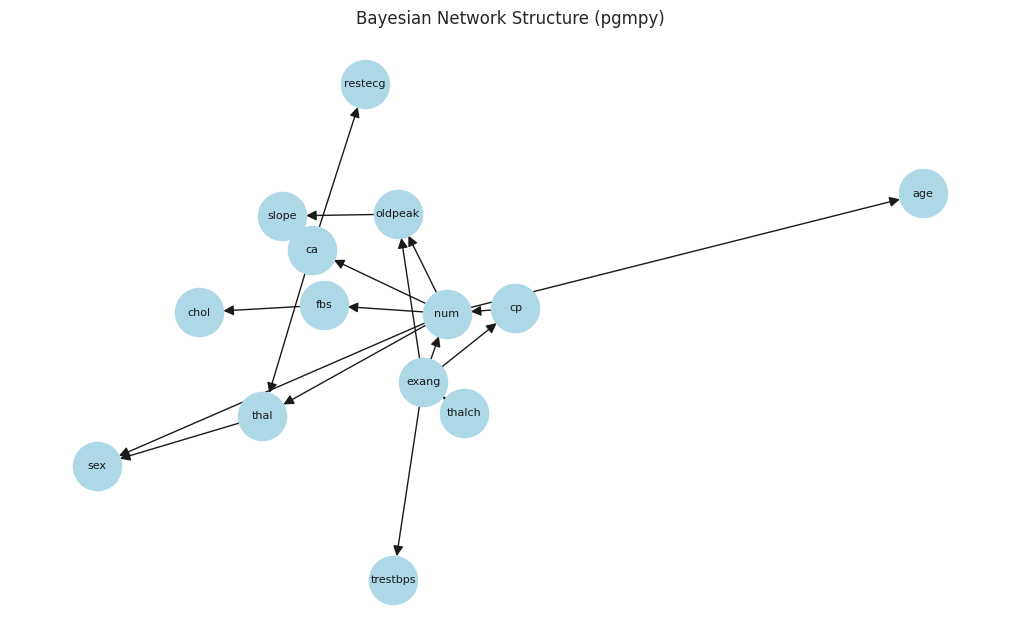

pgmpy Accuracy: 0.7717391304347826
pgmpy AUC: 0.8101386896221903
pgmpy Train time: 2.58s


/usr/local/lib/python3.12/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / (phi.values.sum())


In [8]:
# =======================================================
# 5. Bayesian Network với pgmpy
# =======================================================
start = time.time()
hc = HillClimbSearch(train_df)
best_model = hc.estimate(max_indegree=3, tabu_length=10)
pgmpy_time = time.time() - start

print("Learned edges (pgmpy):", best_model.edges())

# Vẽ cấu trúc mạng
plt.figure(figsize=(10,6))
G = nx.DiGraph()
G.add_nodes_from(train_df.columns)
G.add_edges_from(best_model.edges())
pos = nx.spring_layout(G, seed=1)
nx.draw(G, pos, with_labels=True, node_size=1200, node_color='lightblue', font_size=8, arrowsize=15)
plt.title("Bayesian Network Structure (pgmpy)")
plt.show()

# Parameter learning
model_pgmpy = PgmpyBN(best_model.edges())
model_pgmpy.fit(train_df, estimator=MaximumLikelihoodEstimator)
infer_pgmpy = VariableElimination(model_pgmpy)

def pgmpy_predict(df_features):
    preds, probs = [], []
    for _, row in df_features.iterrows():
        evidence = row.to_dict()
        try:
            q = infer_pgmpy.query(variables=[target_col], evidence=evidence, show_progress=False)
            states = q.state_names[target_col]
            vals = q.values.flatten()
            if np.isnan(vals).any():
                p1 = 0.5
            else:
                p1 = float(vals[states.index('1')]) if '1' in states else 0.0
        except:
            p1 = 0.5
        probs.append(p1)
        preds.append(1 if p1 >= 0.5 else 0)
    return np.array(preds), np.array(probs)

pgm_preds, pgm_probs = pgmpy_predict(X_test)

print("pgmpy Accuracy:", accuracy_score(y_test, pgm_preds))
print("pgmpy AUC:", roc_auc_score(y_test, pgm_probs))
print("pgmpy Train time: %.2fs" % pgmpy_time)

In [ ]:
import time
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score

# Import cho Markov Network và Factors
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor # Dùng để định nghĩa tham số thủ công
from pgmpy.sampling import GibbsSampling

target_col = "num"
mrf_start = time.time()

# 1. ĐỊNH NGHĨA CẤU TRÚC (VÔ HƯỚNG)
# Định nghĩa các cạnh vô hướng để tạo ra 2 cụm (cliques)
mrf_edges = [
    (target_col, 'sex'), (target_col, 'cp'), ('sex', 'cp'), # Clique 1: num, sex, cp
    ('age', 'chol'),                                        # Clique 2: age, chol
    ('cp', 'thal')                                          # Liên kết cp và thal
]
model_mrf = MarkovNetwork(mrf_edges)

# 2. HỌC THAM SỐ (PARAMETER LEARNING)
# Lấy các giá trị category duy nhất của các cột
def get_unique_lens(cols):
    """Lấy độ dài các trạng thái duy nhất, dùng cho kích thước Factor."""
    return [len(train_df[col].unique()) for col in cols]

# Factor 1: num, sex, cp
try:
    cols1 = [target_col, 'sex', 'cp']
    lens1 = get_unique_lens(cols1)
    factor_1 = DiscreteFactor(cols1, lens1, np.random.rand(np.prod(lens1)))
    factor_1.normalize()
    model_mrf.add_factors(factor_1)
except Exception as e:
    print(f"Bỏ qua Factor 1 do lỗi định nghĩa: {e}")

# Factor 2: age, chol
try:
    cols2 = ['age', 'chol']
    lens2 = get_unique_lens(cols2)
    factor_2 = DiscreteFactor(cols2, lens2, np.random.rand(np.prod(lens2)))
    factor_2.normalize()
    model_mrf.add_factors(factor_2)
except Exception as e:
    print(f"Bỏ qua Factor 2 do lỗi định nghĩa: {e}")

# Factor 3: cp, thal
try:
    cols3 = ['cp', 'thal']
    lens3 = get_unique_lens(cols3)
    factor_3 = DiscreteFactor(cols3, lens3, np.random.rand(np.prod(lens3)))
    factor_3.normalize()
    model_mrf.add_factors(factor_3)
except Exception as e:
    print(f"Bỏ qua Factor 3 do lỗi định nghĩa: {e}")

print("Học tham số Markov Network thành công (Sử dụng tham số ngẫu nhiên để demo cấu trúc).")


# 3. HÀM DỰ ĐOÁN (PREDICTION) - Sử dụng Gibbs Sampling
sampler_mrf = GibbsSampling(model_mrf)

def pgmpy_mrf_predict(df_features, n_samples=1000):
    preds, probs = [], []
    for _, row in df_features.iterrows():
        # Lấy bằng chứng (evidence) từ hàng test
        evidence = row.drop(target_col, errors='ignore').dropna().to_dict()

        try:
            # Lấy mẫu (sampling) để ước tính xác suất
            samples = sampler_mrf.sample(evidence=evidence, size=n_samples, show_progress=False)

            # Tính xác suất P(target_col = '1')
            if target_col in samples.columns:
                p_dist = samples[target_col].value_counts(normalize=True).get('1', 0.0)
                p1 = p_dist
            else:
                p1 = 0.5

        except Exception as e:
            p1 = 0.5

        probs.append(p1)
        preds.append(1 if p1 >= 0.5 else 0)

    return np.array(preds), np.array(probs)

mrf_preds, mrf_probs = pgmpy_mrf_predict(X_test)

mrf_time = time.time() - mrf_start

# 4. ĐÁNH GIÁ
print("\n--- Kết quả Pgmpy Markov Network (Tham số tùy chỉnh/ngẫu nhiên) ---")
print("pgmpy Markov Network Accuracy:", accuracy_score(y_test, mrf_preds))
print("pgmpy Markov Network AUC:", roc_auc_score(y_test, mrf_probs))
print("pgmpy Markov Network Train time: %.2fs" % mrf_time)

Học tham số Markov Network thành công (Sử dụng tham số ngẫu nhiên để demo cấu trúc).

--- Kết quả Pgmpy Markov Network (Tham số tùy chỉnh/ngẫu nhiên) ---
pgmpy Markov Network Accuracy: 0.5543478260869565
pgmpy Markov Network AUC: 0.5
pgmpy Markov Network Train time: 0.10s


In [12]:
# =======================================================
# Bayesian Network với pomegranate (API mới 0.19+)
# =======================================================
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder


# -------------------------------------------------------
# 1. Chuẩn bị dữ liệu (đã rời rạc hóa trước đó)
# -------------------------------------------------------
df_pom = df_disc.copy()

# Encode nhãn thành số nguyên vì Categorical yêu cầu numeric
label_encoders = {}
for col in df_pom.columns:
    le = LabelEncoder()
    df_pom[col] = le.fit_transform(df_pom[col])
    label_encoders[col] = le

# Train/test split
train_pom, test_pom = train_test_split(
    df_pom, test_size=0.1,
    stratify=df_pom[target_col],
    random_state=42
)

X_train_pom = train_pom.values
X_test_pom = test_pom.drop(columns=[target_col]).values
y_test_pom = test_pom[target_col].values

# -------------------------------------------------------
# 2. Huấn luyện Bayesian Network với pomegranate
# -------------------------------------------------------
start = time.time()
pom_model = PomBN()
pom_model = pom_model.fit(
    X_train_pom,
    algorithm="chow-liu",        # hoặc "exact", "greedy"
    state_names=df_pom.columns
)
pom_time = time.time() - start

print("pomegranate Train time: %.2fs" % pom_time)
print("Structure:", pom_model.structure)
print("Distributions:", pom_model.distributions)

# -------------------------------------------------------
# 3. Dự đoán với test set
# -------------------------------------------------------
probs = pom_model.predict_proba(X_test_pom)

# Lấy index của cột target
target_idx = list(df_pom.columns).index(target_col)

pom_probs = []
pom_preds = []
for row in probs:
    node_val = row[target_idx]
    if isinstance(node_val, np.ndarray):
        p1 = node_val[1]   # xác suất class = 1
    else:
        p1 = 0.5           # fallback nếu không phải array
    pom_probs.append(p1)
    pom_preds.append(1 if p1 >= 0.5 else 0)

pom_probs = np.array(pom_probs)
pom_preds = np.array(pom_preds)

# -------------------------------------------------------
# 4. Đánh giá
# -------------------------------------------------------
print("pomegranate Accuracy:", accuracy_score(y_test_pom, pom_preds))
print("pomegranate AUC:", roc_auc_score(y_test_pom, pom_probs))


TypeError: BayesianNetwork.fit() got an unexpected keyword argument 'algorithm'